<h1>
    <center>
        Bitcoin Price Prediction
    </center>
</h1>




---



---
## Contents
1. ### Prediction
  * Linear Regression
  * Polynomial Regression
  * KRR
  * GPR 
    * GPR with RBF Kernel
    * GPR with White Kernel
    * GPR with Relational Quadratic Kernel
    * GPR with ExpSine Kernel
    * GPR with Matern Kernel
  * Conclusions
2. ### Demo: Using fbphophet Library For Prediction 
3. ### Curve Smoothing 
4. ### References 


**Importing Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, DotProduct, Matern 
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Predict Bitcoin Values For 6 April To 20 April

**Loading Data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DV/Bitcoin.csv')

**Sample Data**

In [ ]:
df.tail()

,Date,Price
385,01-Apr-21,"58,718.30"
386,02-Apr-21,"58,977.30"
387,03-Apr-21,"57,059.90"
388,04-Apr-21,"58,199.90"
389,05-Apr-21,"58,993.40"


**Column Types**

In [ ]:
df.dtypes

Date     object
Price    object
dtype: object

Since we have to perform regression and both the columns have string datatype, therefore we will be converting those to numerical datatype.

In [ ]:
df['Price'] = df['Price'].apply(lambda x: x.replace(',', ''))
df['Price'] = df['Price'].astype(float)

Adding Date Ordinal Column

In [ ]:
df['Date'] = pd.to_datetime(df['Date']).dt.date 
df['Date_Ordinal'] = df['Date'].map(dt.datetime.toordinal)

In [ ]:
df.dtypes

Date             object
Price           float64
Date_Ordinal      int64
dtype: object

**Sample Data After Processing**

In [ ]:
df.head()

,Date,Price,Date_Ordinal
0,2020-03-12,4826.0,737496
1,2020-03-13,5584.3,737497
2,2020-03-14,5182.7,737498
3,2020-03-15,5366.3,737499
4,2020-03-16,5030.0,737500


In [ ]:
df.tail()

,Date,Price,Date_Ordinal
385,2021-04-01,58718.3,737881
386,2021-04-02,58977.3,737882
387,2021-04-03,57059.9,737883
388,2021-04-04,58199.9,737884
389,2021-04-05,58993.4,737885


**Function To Plot Graph**

In [ ]:
def data_plot(args):
  sns.set_style('whitegrid')
  f, ax = plt.subplots(figsize=(18, 6))
  if args:
    for arg in args:
      eval(arg)
  btplot = sns.lineplot(x='Date', y='Price', data=df, ax=ax, color='b')
  btplot.spines['top'].set_visible(False)
  btplot.spines['right'].set_visible(False)
  btplot.spines['left'].set_linewidth(3)
  btplot.spines['bottom'].set_linewidth(3)
  plt.show()

**Plot Actual Data**

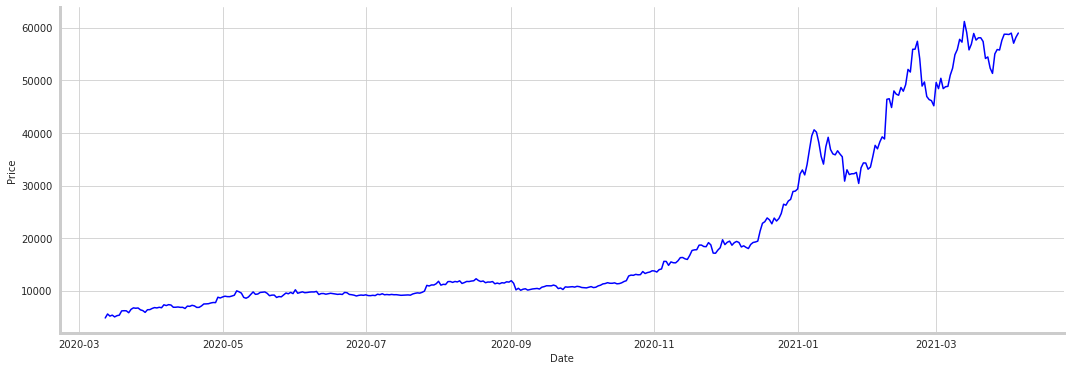

In [ ]:
data_plot([])

**Creating Future Dates Dataframe**

In [ ]:
future_date_ordinal = [i + df.iloc[-1, 2] for i in range(1, 16)]

In [ ]:
future_date = [date.fromordinal(i) for i in future_date_ordinal]

In [ ]:
future_df = pd.DataFrame({'Future_Date':future_date,
                      'Future_Date_Ordinal':future_date_ordinal})
future_df

,Future_Date,Future_Date_Ordinal
0,2021-04-06,737886
1,2021-04-07,737887
2,2021-04-08,737888
3,2021-04-09,737889
4,2021-04-10,737890
5,2021-04-11,737891
6,2021-04-12,737892
7,2021-04-13,737893
8,2021-04-14,737894
9,2021-04-15,737895


**Function To Print Model Parameters**

In [ ]:
def model_paras(model):
  print(f'Intercept: {model.intercept_}')
  print(f'Coeficient: {model.coef_}')

**Input & Target Variable**

In [ ]:
X = df.Date_Ordinal.values
X = X[:, np.newaxis]

y = df['Price'].values
y = y[:, np.newaxis]

## Method 1: Linear Regression

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [ ]:
mod1 = LinearRegression()
mod1.fit(X, y)
y1_pred = mod1.predict(X)

In [ ]:
model_paras(mod1)

Intercept: [-90076362.90295626]
Coeficient: [[122.133012]]


In [ ]:
mod1.score(X, y)

0.7385771218889646

**Linear Regression Plot**

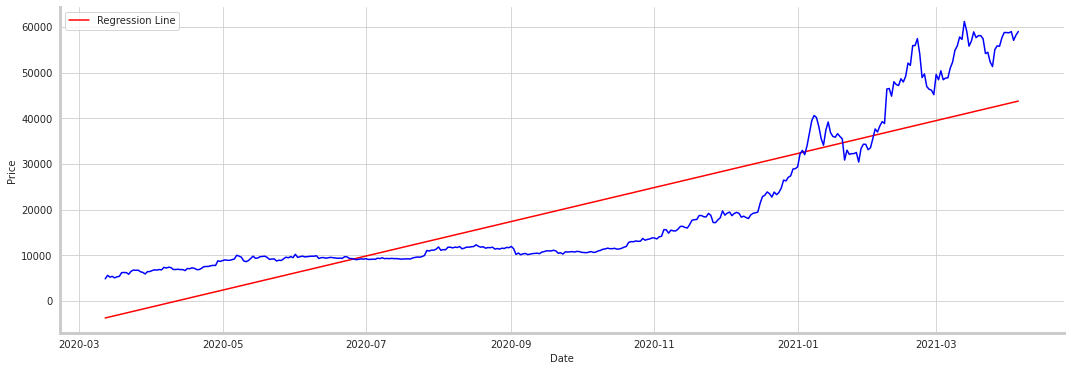

In [ ]:
data_plot(["plt.plot(X, y1_pred, color='r', label='Regression Line')"])

**Creating Performance Dataframe**

In [ ]:
performance_df = pd.DataFrame({'Model':['LinReg'],
                               'MSE': [round(mean_squared_error(y, y1_pred),2)],
                               'R2 Score': [mod1.score(X,y)]})

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,66920470.97,0.738577


In [ ]:
X_f = future_df.Future_Date_Ordinal.values
X_f = X_f[:, np.newaxis]

In [ ]:
y1_f_pred = mod1.predict(X_f)
future_df['LinReg'] = [round(val[0], 2) for val in y1_f_pred]

Adding linear regression predictions to `future_df`

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg
0,2021-04-06,737886,43876.79
1,2021-04-07,737887,43998.92
2,2021-04-08,737888,44121.06
3,2021-04-09,737889,44243.19
4,2021-04-10,737890,44365.32
5,2021-04-11,737891,44487.46
6,2021-04-12,737892,44609.59
7,2021-04-13,737893,44731.72
8,2021-04-14,737894,44853.85
9,2021-04-15,737895,44975.99


**Linear Regression Prediction Plot**

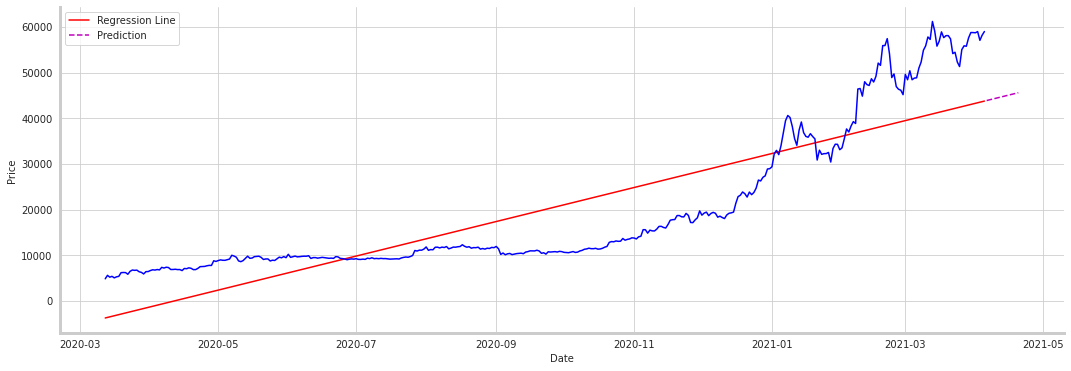

In [ ]:
data_plot(["plt.plot(X, y1_pred, color='r', label='Regression Line')",
           "plt.plot(X_f, y1_f_pred, '--', color='m', label='Prediction')"])

## Method 2: Polynomial Regression

In [ ]:
polynomial_features = PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)
mod2 = LinearRegression()
mod2.fit(X_poly, y)
y2_pred = mod2.predict(X_poly)

In [ ]:
model_paras(mod2)

Intercept: [3.49100201e+11]
Coeficient: [[ 0.00000000e+00 -9.46590033e+05  6.41673009e-01]]


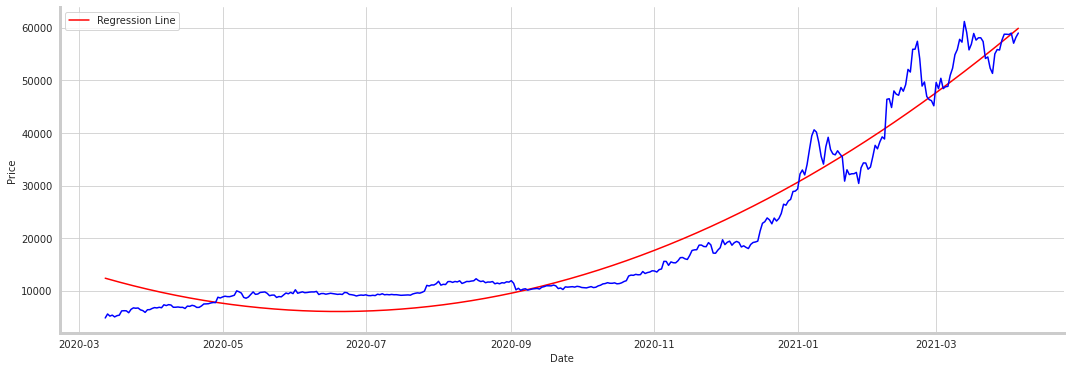

In [ ]:
data_plot(["plt.plot(X, y2_pred, color='r', label='Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['PolyRegDeg-2'],
                                         'MSE': [round(mean_squared_error(y, y2_pred),2)],
                                         'R2 Score': [mod2.score(X_poly, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,66920470.97,0.738577
0,PolyRegDeg-2,14002992.81,0.945298


Adding polynomial regression predictions to `future_df`

In [ ]:
X_f_poly = polynomial_features.fit_transform(X_f)
y2_f_pred = mod2.predict(X_f_poly)
future_df['PolyRegDeg-2'] = [round(val[0], 2) for val in y2_f_pred]

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2
0,2021-04-06,737886,43876.79,60268.55
1,2021-04-07,737887,43998.92,60642.22
2,2021-04-08,737888,44121.06,61017.18
3,2021-04-09,737889,44243.19,61393.41
4,2021-04-10,737890,44365.32,61770.93
5,2021-04-11,737891,44487.46,62149.73
6,2021-04-12,737892,44609.59,62529.82
7,2021-04-13,737893,44731.72,62911.19
8,2021-04-14,737894,44853.85,63293.84
9,2021-04-15,737895,44975.99,63677.77


**Ploynomial Regression Prediction Plot**

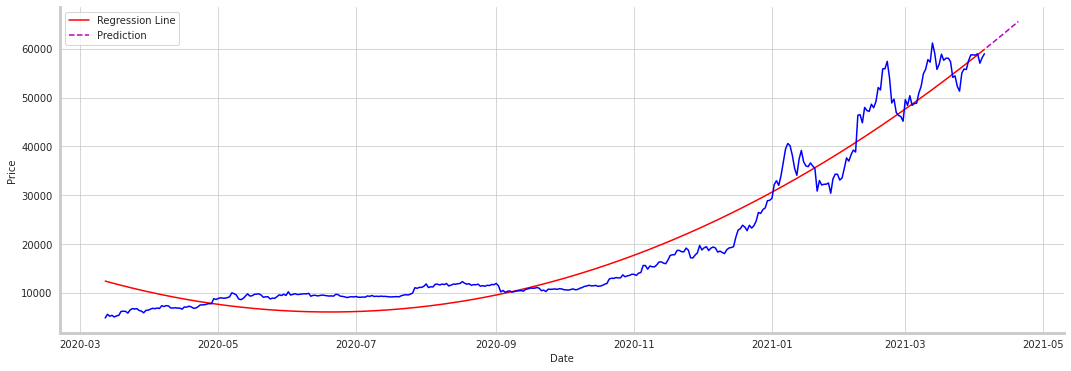

In [ ]:
data_plot(["plt.plot(X, y2_pred, color='r', label='Regression Line')",
           "plt.plot(X_f, y2_f_pred, '--', color='m', label='Prediction')"])

## Method 3: KRR

Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

In [ ]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}

mod3 = GridSearchCV(KernelRidge(), param_grid=param_grid)
mod3.fit(X, y)

y3_pred = mod3.predict(X)

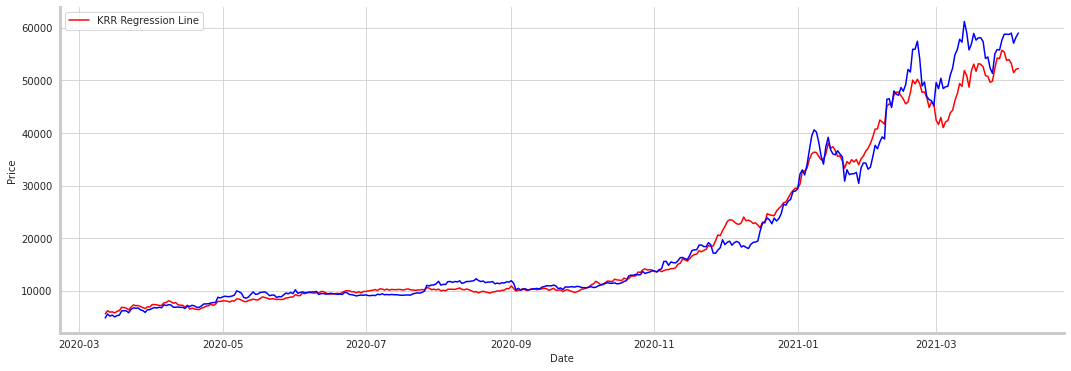

In [ ]:
data_plot(["plt.plot(X, y3_pred, color='r', label='KRR Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['KRR'],
                                         'MSE': [round(mean_squared_error(y, y3_pred),2)],
                                         'R2 Score': [mod3.score(X, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,66920470.97,0.738577
0,PolyRegDeg-2,14002992.81,0.945298
0,KRR,5874374.32,0.977052


Adding KRR predictions to `future_df`

In [ ]:
y3_f_pred = mod3.predict(X_f)
future_df['KRR'] = [round(val[0], 2) for val in y3_f_pred]

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2,KRR
0,2021-04-06,737886,43876.79,60268.55,43372.31
1,2021-04-07,737887,43998.92,60642.22,42353.35
2,2021-04-08,737888,44121.06,61017.18,44345.88
3,2021-04-09,737889,44243.19,61393.41,41989.19
4,2021-04-10,737890,44365.32,61770.93,42748.31
5,2021-04-11,737891,44487.46,62149.73,42441.47
6,2021-04-12,737892,44609.59,62529.82,44254.63
7,2021-04-13,737893,44731.72,62911.19,44819.88
8,2021-04-14,737894,44853.85,63293.84,47271.92
9,2021-04-15,737895,44975.99,63677.77,48231.91


**KRR Prediction Plot**

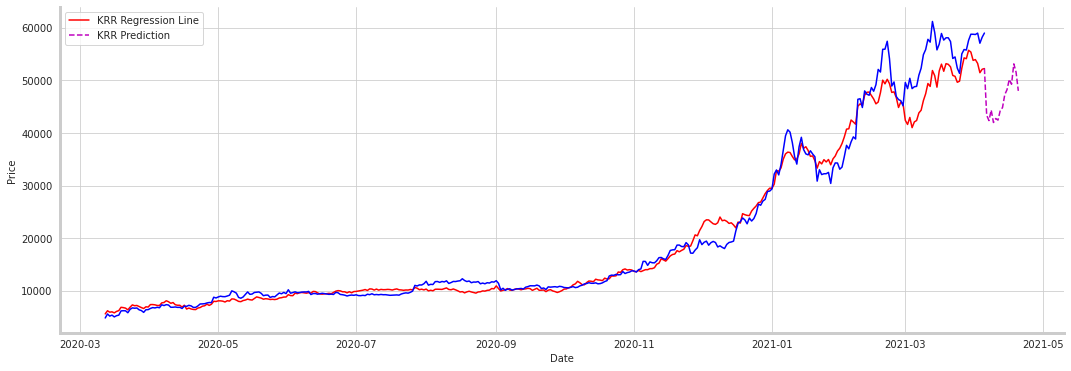

In [ ]:
a = np.concatenate((X[-1], X_f), axis=None)
kr = np.concatenate((y3_pred[-1], y3_f_pred), axis=None)
data_plot(["plt.plot(X, y3_pred, color='r', label='KRR Regression Line')",
           "plt.plot(a, kr, '--', color='m', label='KRR Prediction')"])

## Method 4: GPR

The GaussianProcessRegressor implements Gaussian processes (GP) for regression purposes. For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by passing a kernel object.

**GPR With RBF Kernel**

In [ ]:
sigma_f = 2
kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e3))
mod4 = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10).fit(X, y)
y4_pred = mod4.predict(X)

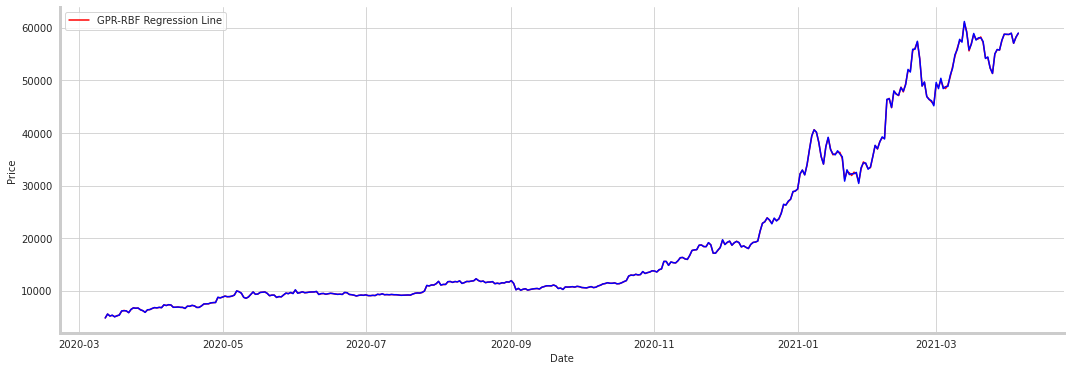

In [ ]:
data_plot(["plt.plot(X, y4_pred, color='r', label='GPR-RBF Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['GPR-RBF'],
                                         'MSE': [round(mean_squared_error(y, y4_pred),2)],
                                         'R2 Score': [mod4.score(X, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,66920470.97,0.738577
0,PolyRegDeg-2,14002992.81,0.945298
0,KRR,5874374.32,0.977052
0,GPR-RBF,10539.23,0.999959


In [ ]:
y4_f_pred = mod4.predict(X_f)
future_df['GPR-RBF'] = [round(val[0], 2) for val in y4_f_pred]

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2,KRR,GPR-RBF
0,2021-04-06,737886,43876.79,60268.55,43372.31,44096.70
1,2021-04-07,737887,43998.92,60642.22,42353.35,20603.81
2,2021-04-08,737888,44121.06,61017.18,44345.88,5738.82
3,2021-04-09,737889,44243.19,61393.41,41989.19,945.23
4,2021-04-10,737890,44365.32,61770.93,42748.31,92.10
5,2021-04-11,737891,44487.46,62149.73,42441.47,5.32
6,2021-04-12,737892,44609.59,62529.82,44254.63,0.18
7,2021-04-13,737893,44731.72,62911.19,44819.88,0.00
8,2021-04-14,737894,44853.85,63293.84,47271.92,0.00
9,2021-04-15,737895,44975.99,63677.77,48231.91,0.00


**GPR Prediction Plot**

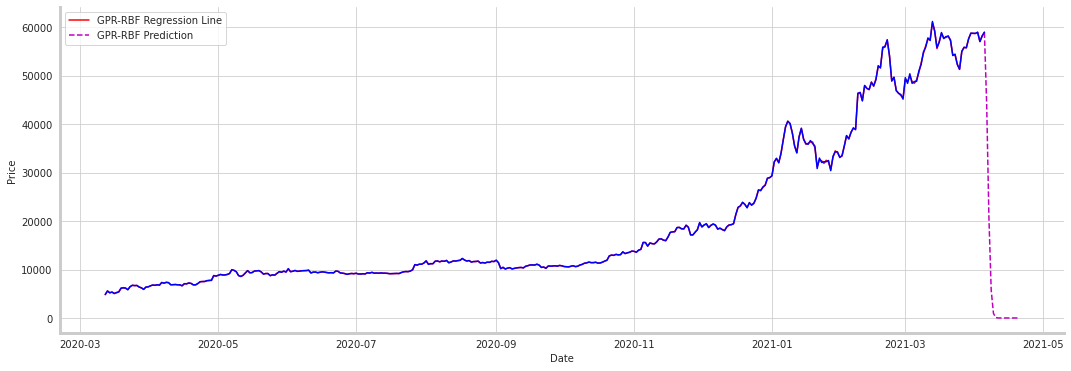

In [ ]:
gpr = np.concatenate((y4_pred[-1], y4_f_pred), axis=None)
data_plot(["plt.plot(X, y4_pred, color='r', label='GPR-RBF Regression Line')",
           "plt.plot(a, gpr, '--', color='m', label='GPR-RBF Prediction')"])

**GPR With White Kernel**

In [ ]:
kernel = DotProduct() + WhiteKernel()
mod5 = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10).fit(X, y)
y5_pred = mod5.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


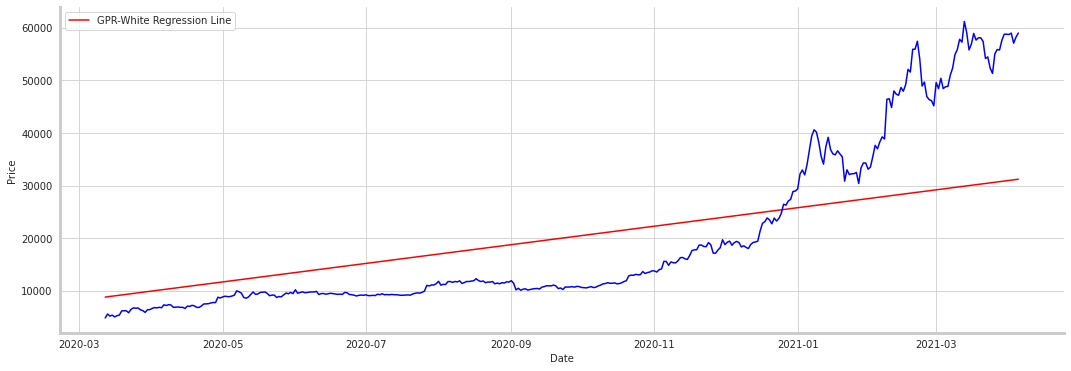

In [ ]:
data_plot(["plt.plot(X, y5_pred, color='r', label='GPR-White Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['GPR-White'],
                                         'MSE': [round(mean_squared_error(y, y5_pred),2)],
                                         'R2 Score': [mod5.score(X, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,6.692047e+07,0.738577
0,PolyRegDeg-2,1.400299e+07,0.945298
0,KRR,5.874374e+06,0.977052
0,GPR-RBF,1.053923e+04,0.999959
0,GPR-White,1.197157e+08,0.532334


In [ ]:
y5_f_pred = mod5.predict(X_f)
future_df['GPR-White'] = [round(val[0], 2) for val in y5_f_pred]

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2,KRR,GPR-RBF,GPR-White
0,2021-04-06,737886,43876.79,60268.55,43372.31,44096.70,31260.43
1,2021-04-07,737887,43998.92,60642.22,42353.35,20603.81,31318.02
2,2021-04-08,737888,44121.06,61017.18,44345.88,5738.82,31375.62
3,2021-04-09,737889,44243.19,61393.41,41989.19,945.23,31433.21
4,2021-04-10,737890,44365.32,61770.93,42748.31,92.10,31490.81
5,2021-04-11,737891,44487.46,62149.73,42441.47,5.32,31548.40
6,2021-04-12,737892,44609.59,62529.82,44254.63,0.18,31605.99
7,2021-04-13,737893,44731.72,62911.19,44819.88,0.00,31663.58
8,2021-04-14,737894,44853.85,63293.84,47271.92,0.00,31721.18
9,2021-04-15,737895,44975.99,63677.77,48231.91,0.00,31778.77


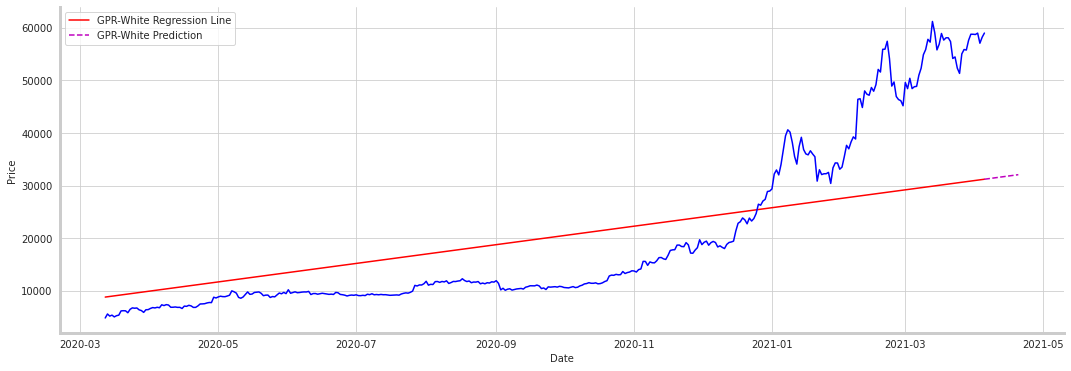

In [ ]:
gpr = np.concatenate((y5_pred[-1], y5_f_pred), axis=None)
data_plot(["plt.plot(X, y5_pred, color='r', label='GPR-White Regression Line')",
           "plt.plot(a, gpr, '--', color='m', label='GPR-White Prediction')"])

**GPR With RationalQuadratic Kernel**

In [ ]:
kernel = RationalQuadratic(length_scale=2.0, alpha=5)
mod6 = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10).fit(X, y)
y6_pred = mod6.predict(X)

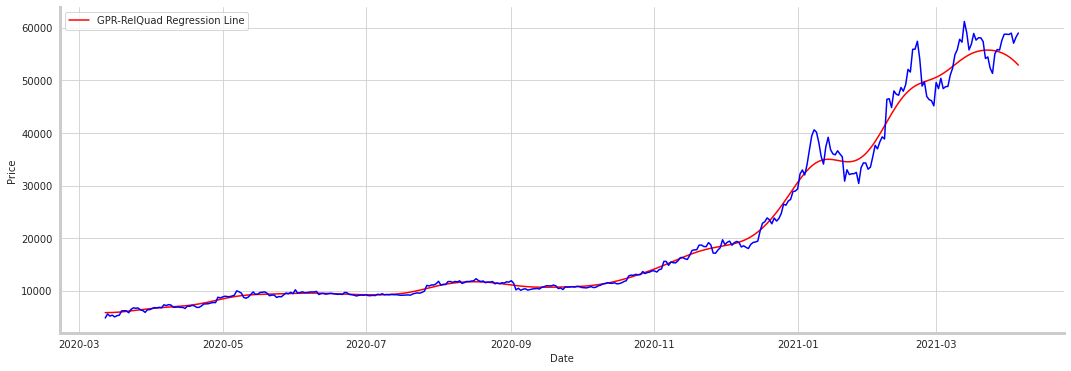

In [ ]:
data_plot(["plt.plot(X, y6_pred, color='r', label='GPR-RelQuad Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['GPR-RelQuad'],
                                         'MSE': [round(mean_squared_error(y, y6_pred),2)],
                                         'R2 Score': [mod6.score(X, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,6.692047e+07,0.738577
0,PolyRegDeg-2,1.400299e+07,0.945298
0,KRR,5.874374e+06,0.977052
0,GPR-RBF,1.053923e+04,0.999959
0,GPR-White,1.197157e+08,0.532334
0,GPR-RelQuad,2.760546e+06,0.989216


In [ ]:
y6_f_pred = mod6.predict(X_f)
future_df['GPR-RelQuad'] = [round(val[0], 2) for val in y6_f_pred]

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2,KRR,GPR-RBF,GPR-White,GPR-RelQuad
0,2021-04-06,737886,43876.79,60268.55,43372.31,44096.70,31260.43,52397.88
1,2021-04-07,737887,43998.92,60642.22,42353.35,20603.81,31318.02,51858.54
2,2021-04-08,737888,44121.06,61017.18,44345.88,5738.82,31375.62,51286.06
3,2021-04-09,737889,44243.19,61393.41,41989.19,945.23,31433.21,50684.88
4,2021-04-10,737890,44365.32,61770.93,42748.31,92.10,31490.81,50059.75
5,2021-04-11,737891,44487.46,62149.73,42441.47,5.32,31548.40,49415.51
6,2021-04-12,737892,44609.59,62529.82,44254.63,0.18,31605.99,48756.90
7,2021-04-13,737893,44731.72,62911.19,44819.88,0.00,31663.58,48088.48
8,2021-04-14,737894,44853.85,63293.84,47271.92,0.00,31721.18,47414.43
9,2021-04-15,737895,44975.99,63677.77,48231.91,0.00,31778.77,46738.57


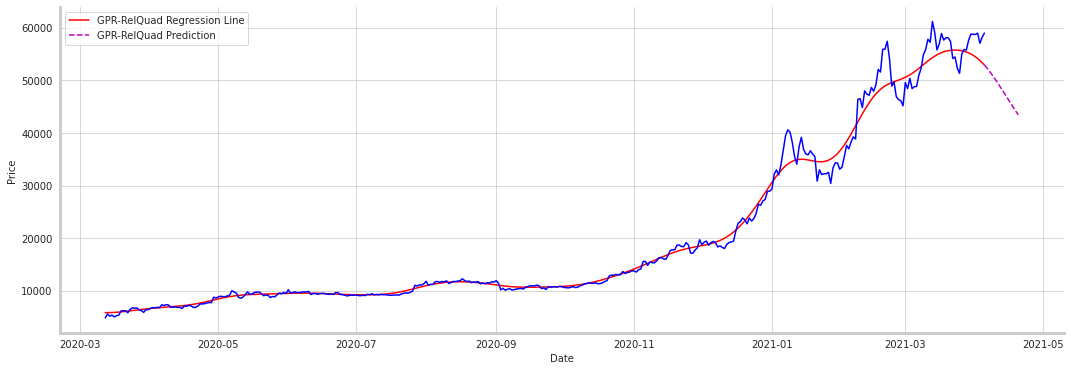

In [ ]:
gpr = np.concatenate((y6_pred[-1], y6_f_pred), axis=None)
data_plot(["plt.plot(X, y6_pred, color='r', label='GPR-RelQuad Regression Line')",
           "plt.plot(a, gpr, '--', color='m', label='GPR-RelQuad Prediction')"])

**GPR With ExpSineSquared Kernel**

In [ ]:
kernel = ExpSineSquared(length_scale=1, periodicity=1)
mod7 = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10).fit(X, y)
y7_pred = mod7.predict(X)

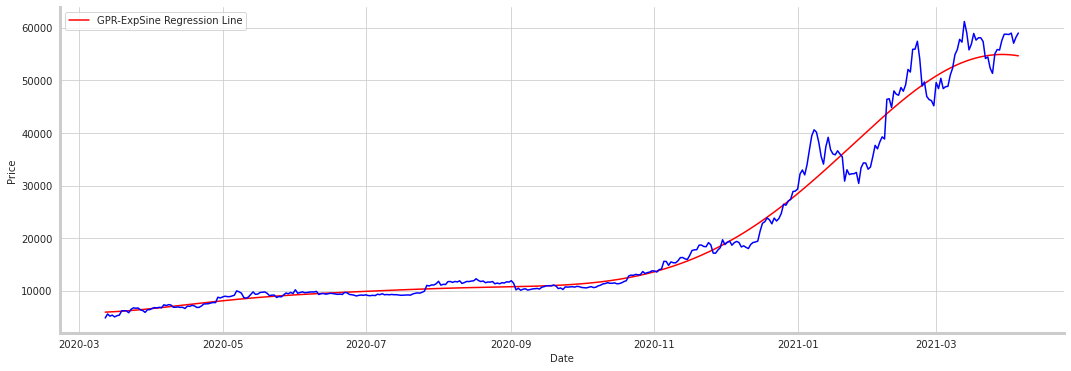

In [ ]:
data_plot(["plt.plot(X, y7_pred, color='r', label='GPR-ExpSine Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['GPR-ExpSine'],
                                         'MSE': [round(mean_squared_error(y, y7_pred),2)],
                                         'R2 Score': [mod7.score(X, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,6.692047e+07,0.738577
0,PolyRegDeg-2,1.400299e+07,0.945298
0,KRR,5.874374e+06,0.977052
0,GPR-RBF,1.053923e+04,0.999959
0,GPR-White,1.197157e+08,0.532334
0,GPR-RelQuad,2.760546e+06,0.989216
0,GPR-ExpSine,5.226513e+06,0.979583


In [ ]:
y7_f_pred = mod7.predict(X_f)
future_df['GPR-ExpSine'] = [round(val[0], 2) for val in y7_f_pred]

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2,KRR,GPR-RBF,GPR-White,GPR-RelQuad,GPR-ExpSine
0,2021-04-06,737886,43876.79,60268.55,43372.31,44096.70,31260.43,52397.88,54586.02
1,2021-04-07,737887,43998.92,60642.22,42353.35,20603.81,31318.02,51858.54,54495.09
2,2021-04-08,737888,44121.06,61017.18,44345.88,5738.82,31375.62,51286.06,54393.50
3,2021-04-09,737889,44243.19,61393.41,41989.19,945.23,31433.21,50684.88,54281.33
4,2021-04-10,737890,44365.32,61770.93,42748.31,92.10,31490.81,50059.75,54158.64
5,2021-04-11,737891,44487.46,62149.73,42441.47,5.32,31548.40,49415.51,54025.53
6,2021-04-12,737892,44609.59,62529.82,44254.63,0.18,31605.99,48756.90,53882.08
7,2021-04-13,737893,44731.72,62911.19,44819.88,0.00,31663.58,48088.48,53728.39
8,2021-04-14,737894,44853.85,63293.84,47271.92,0.00,31721.18,47414.43,53564.56
9,2021-04-15,737895,44975.99,63677.77,48231.91,0.00,31778.77,46738.57,53390.71


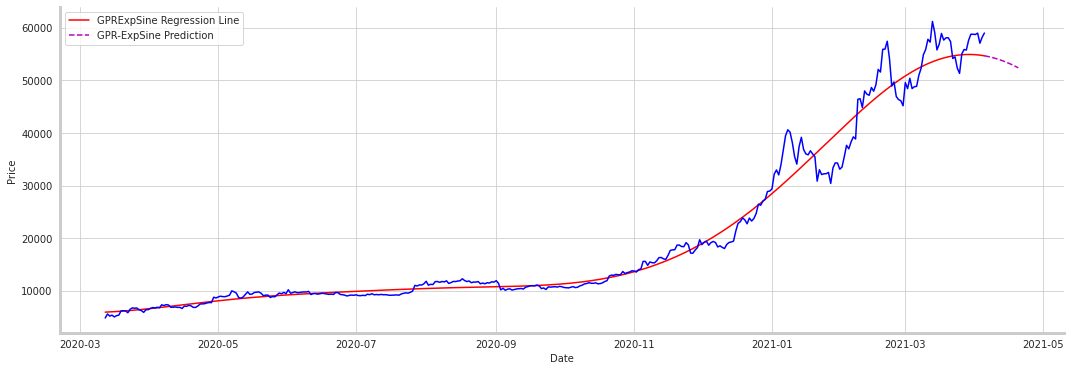

In [ ]:
gpr = np.concatenate((y7_pred[-1], y7_f_pred), axis=None)
data_plot(["plt.plot(X, y7_pred, color='r', label='GPRExpSine Regression Line')",
           "plt.plot(a, gpr, '--', color='m', label='GPR-ExpSine Prediction')"])

**GPR With Matern Kernel**

In [ ]:
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
mod8 = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10).fit(X, y)
y8_pred = mod8.predict(X)

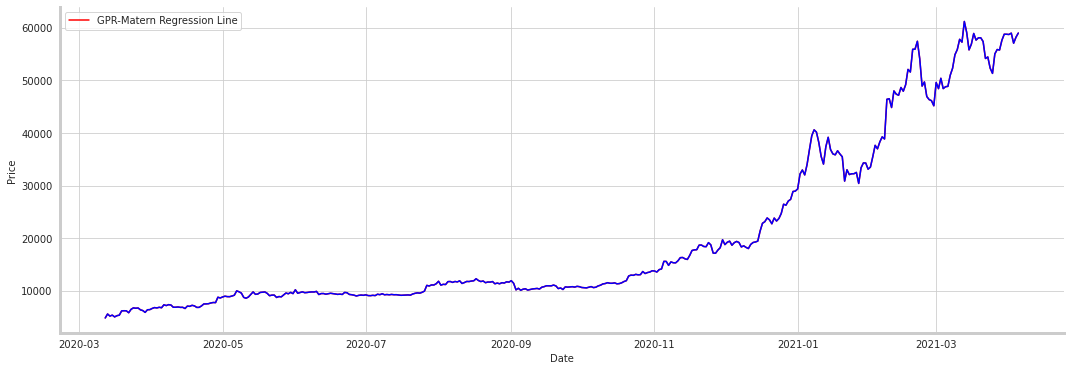

In [ ]:
data_plot(["plt.plot(X, y8_pred, color='r', label='GPR-Matern Regression Line')"])

In [ ]:
performance_df = pd.concat([performance_df, 
                           pd.DataFrame({'Model':['GPR-Matern'],
                                         'MSE': [round(mean_squared_error(y, y8_pred),2)],
                                         'R2 Score': [mod8.score(X, y)]})])

In [ ]:
performance_df

,Model,MSE,R2 Score
0,LinReg,6.692047e+07,0.738577
0,PolyRegDeg-2,1.400299e+07,0.945298
0,KRR,5.874374e+06,0.977052
0,GPR-RBF,1.053923e+04,0.999959
0,GPR-White,1.197157e+08,0.532334
0,GPR-RelQuad,2.760546e+06,0.989216
0,GPR-ExpSine,5.226513e+06,0.979583
0,GPR-Matern,2.700000e-01,1.000000


In [ ]:
y8_f_pred = mod8.predict(X_f)
future_df['GPR-Matern'] = [round(val[0], 2) for val in y8_f_pred]

**Predictions For All The Models**

In [ ]:
future_df

,Future_Date,Future_Date_Ordinal,LinReg,PolyRegDeg-2,KRR,GPR-RBF,GPR-White,GPR-RelQuad,GPR-ExpSine,GPR-Matern
0,2021-04-06,737886,43876.79,60268.55,43372.31,44096.70,31260.43,52397.88,54586.02,54311.25
1,2021-04-07,737887,43998.92,60642.22,42353.35,20603.81,31318.02,51858.54,54495.09,46444.82
2,2021-04-08,737888,44121.06,61017.18,44345.88,5738.82,31375.62,51286.06,54393.50,37957.12
3,2021-04-09,737889,44243.19,61393.41,41989.19,945.23,31433.21,50684.88,54281.33,30082.15
4,2021-04-10,737890,44365.32,61770.93,42748.31,92.10,31490.81,50059.75,54158.64,23317.68
5,2021-04-11,737891,44487.46,62149.73,42441.47,5.32,31548.40,49415.51,54025.53,17773.36
6,2021-04-12,737892,44609.59,62529.82,44254.63,0.18,31605.99,48756.90,53882.08,13370.37
7,2021-04-13,737893,44731.72,62911.19,44819.88,0.00,31663.58,48088.48,53728.39,9952.31
8,2021-04-14,737894,44853.85,63293.84,47271.92,0.00,31721.18,47414.43,53564.56,7343.95
9,2021-04-15,737895,44975.99,63677.77,48231.91,0.00,31778.77,46738.57,53390.71,5379.95


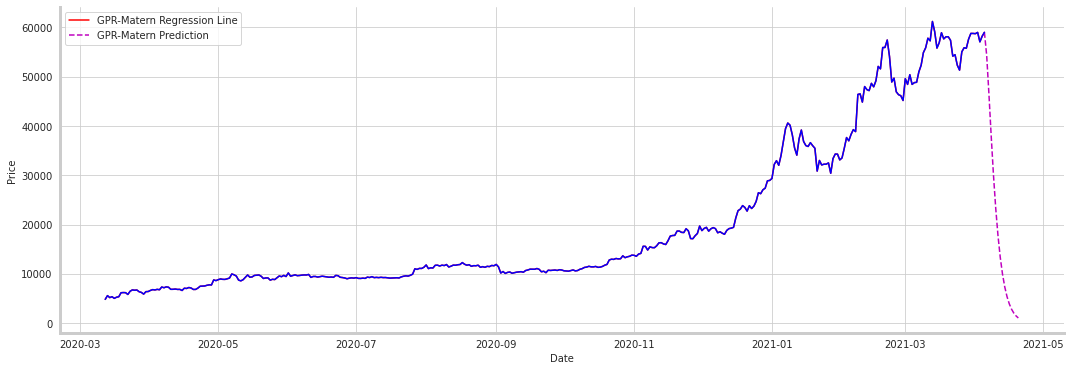

In [ ]:
gpr = np.concatenate((y8_pred[-1], y8_f_pred), axis=None)
data_plot(["plt.plot(X, y8_pred, color='r', label='GPR-Matern Regression Line')",
           "plt.plot(a, gpr, '--', color='m', label='GPR-Matern Prediction')"])

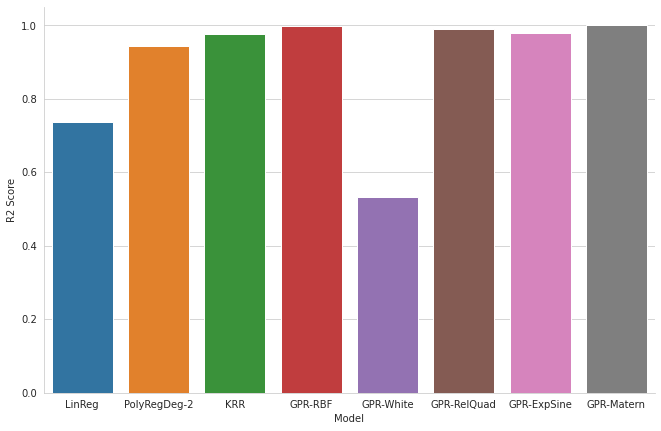

In [ ]:
r2_plot = sns.catplot(x='Model', y='R2 Score', data=performance_df, kind='bar')
r2_plot.fig.set_size_inches(10,6)
plt.show()

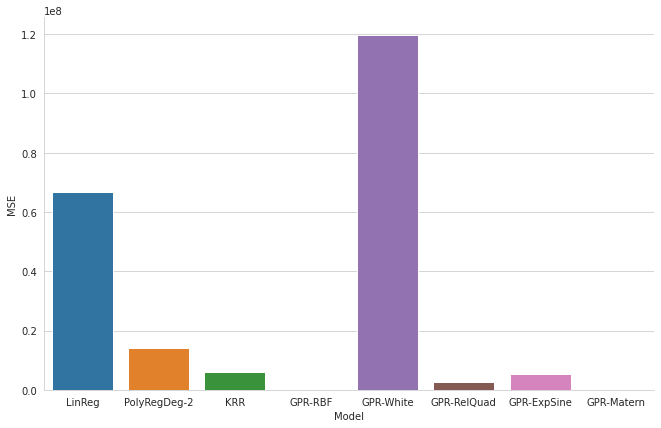

In [ ]:
mse_plot = sns.catplot(x='Model', y='MSE', data=performance_df, kind='bar')
mse_plot.fig.set_size_inches(10,6)
plt.show()

## Conclusions

---

* **Polynomial Regression (degree 2), KRR and GPR with ExpSine kernel** can be **good models** to predict Bitcoin price value as for these two models the **mean square error is less** and the **R2 score is also good**. The values predicted by these models apprear to be realistic.
* Rest all other models have high mean square error or are overfitting resulting in poor predictions.

## Demo: Using fbphophet Library For Prediction

In [ ]:
from fbprophet import Prophet

In [ ]:
df1 = df.copy()
df1.rename(columns={'Date':'ds','Price':'y'}, inplace=True)
df1.drop(columns=['Date_Ordinal'], inplace=True)
df1.head()

,ds,y
0,2020-03-12,4826.0
1,2020-03-13,5584.3
2,2020-03-14,5182.7
3,2020-03-15,5366.3
4,2020-03-16,5030.0


In [ ]:
m = Prophet()
m.fit(df1)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=15)
m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-12,5942.194691,2888.823833,9014.502988,5942.194691,5942.194691,1.923900,1.923900,1.923900,1.923900,1.923900,1.923900,0.0,0.0,0.0,5944.118591
1,2020-03-13,5986.590105,3118.219247,8964.579049,5986.590105,5986.590105,66.089235,66.089235,66.089235,66.089235,66.089235,66.089235,0.0,0.0,0.0,6052.679340
2,2020-03-14,6030.985519,3141.470533,9009.184031,6030.985519,6030.985519,82.052281,82.052281,82.052281,82.052281,82.052281,82.052281,0.0,0.0,0.0,6113.037800
3,2020-03-15,6075.380933,3108.632595,8816.678289,6075.380933,6075.380933,-90.538857,-90.538857,-90.538857,-90.538857,-90.538857,-90.538857,0.0,0.0,0.0,5984.842076
4,2020-03-16,6119.776347,3173.448992,9238.621590,6119.776347,6119.776347,-62.888038,-62.888038,-62.888038,-62.888038,-62.888038,-62.888038,0.0,0.0,0.0,6056.888309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2021-04-16,65609.097908,62844.622577,68604.480737,65524.469192,65686.068188,66.089235,66.089235,66.089235,66.089235,66.089235,66.089235,0.0,0.0,0.0,65675.187142
401,2021-04-17,65956.265270,62959.861324,69008.274062,65854.143998,66047.130180,82.052281,82.052281,82.052281,82.052281,82.052281,82.052281,0.0,0.0,0.0,66038.317551
402,2021-04-18,66303.432633,63304.751087,68990.655821,66179.790138,66407.374193,-90.538857,-90.538857,-90.538857,-90.538857,-90.538857,-90.538857,0.0,0.0,0.0,66212.893776
403,2021-04-19,66650.599995,63850.417565,69586.285940,66503.180247,66772.981488,-62.888038,-62.888038,-62.888038,-62.888038,-62.888038,-62.888038,0.0,0.0,0.0,66587.711957


In [ ]:
m.predict(future[-20:])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-04-01,60401.587469,57305.838916,63301.575585,60401.587469,60401.587469,1.923900,1.923900,1.923900,1.923900,1.923900,1.923900,0.0,0.0,0.0,60403.511369
1,2021-04-02,60748.754832,58211.089178,63732.865650,60748.754832,60748.754832,66.089235,66.089235,66.089235,66.089235,66.089235,66.089235,0.0,0.0,0.0,60814.844066
2,2021-04-03,61095.922194,58653.033061,64112.003243,61095.922194,61095.922194,82.052281,82.052281,82.052281,82.052281,82.052281,82.052281,0.0,0.0,0.0,61177.974475
3,2021-04-04,61443.089557,58545.908783,64252.120490,61443.089557,61443.089557,-90.538857,-90.538857,-90.538857,-90.538857,-90.538857,-90.538857,0.0,0.0,0.0,61352.550700
4,2021-04-05,61790.256919,58569.599457,64480.237486,61790.256919,61790.256919,-62.888038,-62.888038,-62.888038,-62.888038,-62.888038,-62.888038,0.0,0.0,0.0,61727.368881
5,2021-04-06,62137.424282,58986.481969,64907.762384,62137.424282,62137.424282,-84.885589,-84.885589,-84.885589,-84.885589,-84.885589,-84.885589,0.0,0.0,0.0,62052.538693
6,2021-04-07,62484.591644,59722.379099,65712.847376,62484.591644,62484.591644,88.247069,88.247069,88.247069,88.247069,88.247069,88.247069,0.0,0.0,0.0,62572.838714
7,2021-04-08,62831.759007,59871.542501,65621.308165,62831.231199,62831.759007,1.923900,1.923900,1.923900,1.923900,1.923900,1.923900,0.0,0.0,0.0,62833.682907
8,2021-04-09,63178.926370,60438.185887,66253.709319,63176.022785,63180.367442,66.089235,66.089235,66.089235,66.089235,66.089235,66.089235,0.0,0.0,0.0,63245.015604
9,2021-04-10,63526.093732,60907.948249,66477.123383,63517.095699,63531.172677,82.052281,82.052281,82.052281,82.052281,82.052281,82.052281,0.0,0.0,0.0,63608.146013


## Smoothing Curve For Bitcoin Data

**Function To Smooth Curve**

In [ ]:
def smooth(y, b):
  box = np.ones(b)/b
  y_smooth = np.convolve(y, box, mode= 'same')
  return y_smooth

**Plotting The Curve**

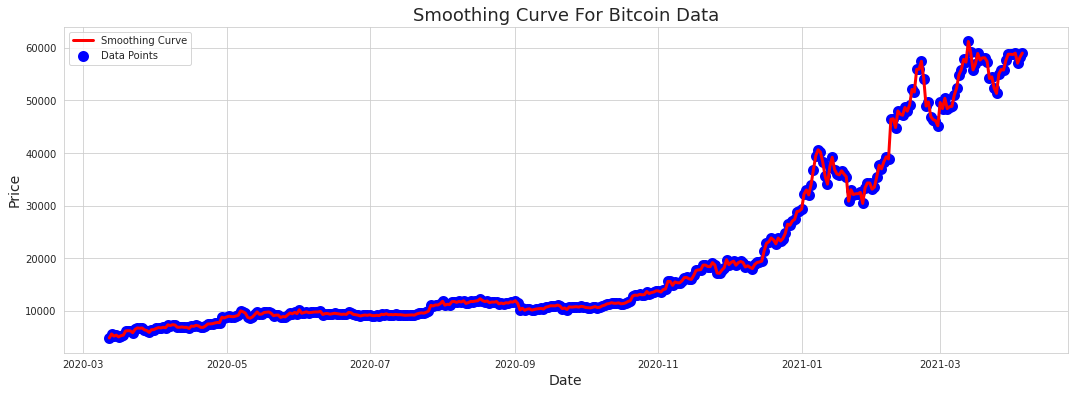

In [ ]:
plt.figure(figsize=(18, 6))
plt.scatter(df['Date'], df['Price'], marker='o', c='b', label='Data Points',lw=5)
plt.plot(df['Date'], smooth(df['Price'].values, 1), c='r', label='Smoothing Curve', lw=3)
plt.title('Smoothing Curve For Bitcoin Data', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.show()

## References

* [Kernel Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
* [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
* [Matern Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern)
* [ExpSine Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html#sklearn.gaussian_process.kernels.ExpSineSquared)
* [RationalQuadratic Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic)
* [Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html)
* [How To Smooth Curve In Right Way](https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way)